# Identify Fraud from Enron Email

## 1. Introduction

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. The purpose of this project is using machine learning methods to identify Enron employees who may have committed fraud based on the public Enron financial and email dataset.

## 2. Data Exploration

The features in the Enron dataset fall into three major types, namely financial features, email features and POI labels.

**financial features**: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

**email features**: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

**POI label**: ['poi'] (boolean, represented as integer)

In [3]:
# Import libraries necessary for this project

import sys
import pickle
sys.path.append("../tools/")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings;
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data

In [16]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# Create DataFrame from dictionary
df = pd.DataFrame.from_dict(data_dict, orient='index', dtype=np.float)
df.reset_index(inplace=True)
df.rename(columns={'index': 'name'}, inplace=True)
df.head()

,name,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
0,ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,...,NaN,2195.0,152.0,65.0,0.0,NaN,-3081055.0,304805.0,phillip.allen@enron.com,47.0
1,BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,...,NaN,29.0,864523.0,0.0,0.0,NaN,-5104.0,NaN,james.bannantine@enron.com,39.0
3,BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,...,NaN,NaN,2660303.0,NaN,0.0,NaN,-1386055.0,1586055.0,NaN,NaN
4,BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,...,NaN,NaN,69.0,NaN,0.0,NaN,-201641.0,NaN,frank.bay@enron.com,NaN


In [17]:
# Select the features to be used
# Put 'poi' as first features and remove 'email_address' and 'name'
features_list = ['poi']  +  [feature for feature in df if feature != 'poi' 
                              and feature != 'email_address' and feature != 'name']

print "List of features:"
print features_list

List of features:
['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']


In [18]:
print "Total number of data points:", df.shape[0]
print "Number of person of interest (POI):", len(df[df['poi']==1])
print "Number of selected features:", len(features_list)

Total number of data points: 146
Number of person of interest (POI): 18
Number of selected features: 20


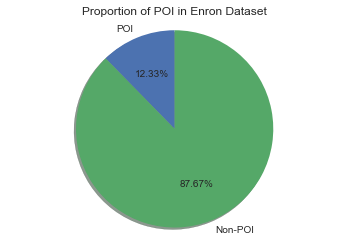

In [12]:
# Plot the proportion of POI
plt.title('Proportion of POI in Enron Dataset')
plt.pie([len(df[df['poi']==1]),len(df[df['poi']==0])], shadow=True, startangle=90, autopct='%1.2f%%', 
        labels =['POI','Non-POI']);
plt.axis('equal');

In this Enron dataset, only 12.33% of the employees are POI. This implies the data has unbalance class distribution where the number of POI is greatly smaller than number of non-POI. 

## 3. Missing  Value and Outlier Investigation

### Missing Values

First we calculate and plot the percentage of missing values in each features.

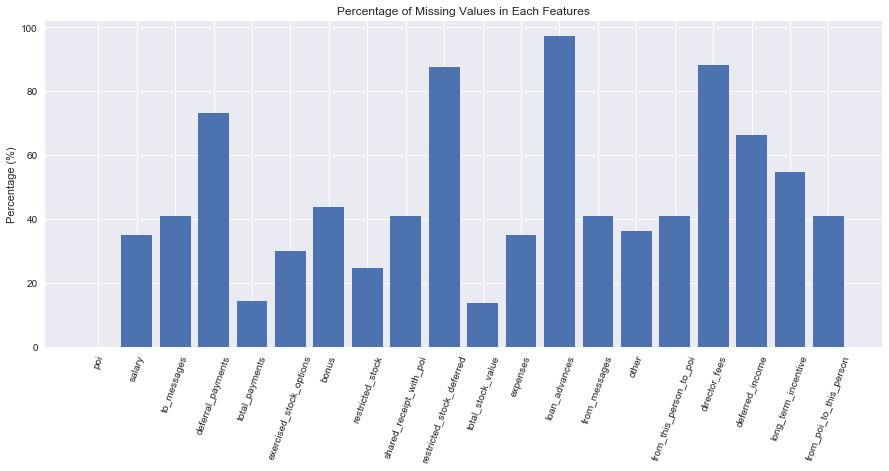

In [19]:
# Calculate the percentage of missing values in each features
nan_percentage = np.array([float(len(df[df[feature].isnull()]))/len(df) for feature in features_list])*100

# Plot the percentage
plt.figure(figsize=(15,6))
y_pos = np.arange(len(features_list))
plt.bar(y_pos,nan_percentage)
plt.xticks(y_pos, features_list, rotation=70);
plt.ylabel('Percentage (%)');
plt.title('Percentage of Missing Values in Each Features');

From the graph, we can see that there are a lot missing values or NaN in the dataset. This is the imperfect data problem commonly found in real-world dataset.

### Outliers

By skimming [enron61702insiderpay.pdf](https://github.com/udacity/ud120-projects/raw/master/final_project/enron61702insiderpay.pdf) file that consists of financial information of Enron employees, we can notice the following outliers from the last two rows of the spreadsheet:  
* **`'TOTAL'`** is the summary of every column in the spreadsheet.
* **`'THE TRAVEL AGENCY IN THE PARK'`** is the account of business-related travel to The Travel Agency in the Park and not an Enron employee.

Next, we examine the person who has NaN value for `'total_payments'` and `'total_stock_value'` (because these two features represent the total sum of payments and stock value).

In [20]:
# Find the person who has NaN value for "total_payments" and "total_stock_value"
df[df['total_payments'].isnull() & df['total_stock_value'].isnull()]

,name,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
23,CHAN RONNIE,NaN,NaN,NaN,NaN,NaN,NaN,32460.0,NaN,-32460.0,...,NaN,NaN,NaN,NaN,0.0,98784.0,-98784.0,NaN,NaN,NaN
84,LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
108,POWERS WILLIAM,NaN,653.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,...,NaN,26.0,NaN,0.0,0.0,17500.0,-17500.0,NaN,ken.powers@enron.com,0.0


For **`'CHAN RONNIE'`**, her `'restricted_stock'` value was offset by `'restricted_stock_deferred'`. Similarly, for **`'POWERS WILLIAM'`**, his `'director_fees'` was offset by `'deferred_income'`. Therefore, the `'total_payments'` and `'total_stock_value'` of these two persons are NaN values.  

The third person, **`'LOCKHART EUGENE E'`** has all NaN value for all the features except for the `"poi"`. I decided to classify **`'LOCKHART EUGENE E'`** as outlier, together with **`'TOTAL'`** and **`'THE TRAVEL AGENCY IN THE PARK'`**. These three outliers will be removed from the dataset.

In [21]:
# Remove the outliers from the dataset
outlier_list = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
df = df[~(df['name'].isin(outlier_list))]
df.reset_index(inplace=True)

## 4. Feature Selection

### New Features
Beside financial information, another possible way to identify POI is by examining the email commutations of the Enron employees. We can guess that employees who involved in the corporate fraud tend to have more email communication among each other. Two new features were created based on this assumption: 
* `'to_poi_ratio'`: the ratio of the `'from_this_person_to_poi'` to `'from_messages'`
* `'from_poi_ratio'`: the ratio of the `'from_poi_to_this_person'` to `'to_messages'`


In [22]:
# Create the two new features
features_list.append('to_poi_ratio')
features_list.append('from_poi_ratio')

df['to_poi_ratio'] = df['from_this_person_to_poi']/df['from_messages']
df['from_poi_ratio'] = df['from_poi_to_this_person']/df['to_messages']

# Before proceeding to next step, 
# we keep the selected features in the dataframe
# and replace NaN with 0
df = df[features_list]
df.fillna(0, inplace=True)

### Feature Scores
To select the best features for prediction models, we use [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) of Sklearn library to evaluate the importance of each features.

In [23]:
# Seperate the label and the features from the dataframe
labels = df['poi']
features = df.drop('poi', axis = 1)

# Scale the features uisng MinMaxScaler function 
features = MinMaxScaler().fit_transform(features)

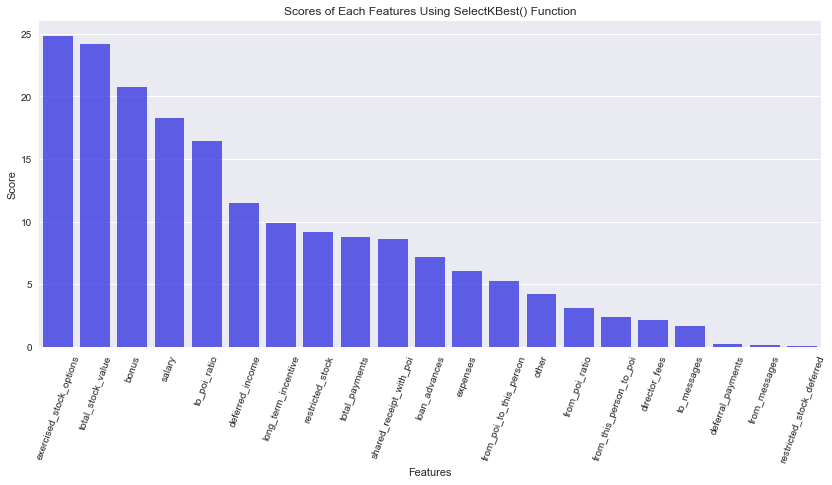

In [25]:
# Compute the scores of each features
k_best = SelectKBest(k = 'all', score_func = f_classif)
k_best.fit(features,labels)
scores = k_best.scores_

# Sort the scores
sorted_scores = list(sorted(zip(features_list[1:], scores), key=lambda x: x[1], reverse = True))
sorted_scores_df = pd.DataFrame(sorted_scores, columns=['Features','Scores'])

# Plot the scores of each features
plt.figure(figsize=(14,6))
sns.barplot(x = 'Features', y ='Scores', data = sorted_scores_df,  color = 'b', alpha=0.7)
plt.xticks( rotation=70);
plt.xlabel('Features')
plt.ylabel('Score')
plt.title("Scores of Each Features Using SelectKBest() Function");


Based on the scores computed by `'SelectKBest'` function, the created new features `'to_poi_ratio'` is one of the top features. I decided to use the top six features with the highest scores (features with score > 10) in the classification models. 

In [26]:
# Select the features with score > 10
selected_features_list = sorted_scores_df[sorted_scores_df['Scores'] > 10]['Features']
selected_features = df[selected_features_list]

# Scale the features uisng MinMaxScaler function 
selected_features = MinMaxScaler().fit_transform(selected_features)

print ('\nSelected features based on SelectKBest scores:')
print (', '.join(selected_features_list))


Selected features based on SelectKBest scores:
exercised_stock_options, total_stock_value, bonus, salary, to_poi_ratio, deferred_income


To validate our feature selection choice, we compare the classification results of Naive Bayes model that use full features and another model that uses only the selected six features.

In [42]:
# Classification using full features

# Seperate the data into training set and test set
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=77)

# Classification using Naive Bayes model
clf_NB = GaussianNB()
clf_NB.fit(features_train, labels_train)
predictions = clf_NB.predict(features_test)
print 'Classification results of using full features:'
print classification_report(labels_test, predictions)

Classification result of using full features:
             precision    recall  f1-score   support

        0.0       0.88      0.19      0.31        37
        1.0       0.14      0.83      0.24         6

avg / total       0.77      0.28      0.30        43



In [50]:
# Classification using only selected top features

# Seperate the data into training set and test set
features_train, features_test, labels_train, labels_test = \
    train_test_split(selected_features, labels, test_size=0.3, random_state=77)
    
# Classification using Naive Bayes model    
clf_NB = GaussianNB()
clf_NB.fit(features_train, labels_train)
predictions = clf_NB.predict(features_test)
print 'Classification results of using selected features:'
print classification_report(labels_test, predictions)

Classification results of using selected features:
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        37
        1.0       1.00      0.33      0.50         6

avg / total       0.92      0.91      0.89        43



From the above classification report, we can see that the average precision, recall and f1-score of using only the selected six features are better than using full features. This justify our feature selection choice.

## 5. Model Selection and Optimization
### Initial Model Evaluation

Four supervised learning classifiers are chosen:
* Naive Bayes 
* Logistic Regression
* Decision Tree
* AdaBoost 

Beside standard accuracy, [F1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) is also used as the metric to compare the classification performance of the machine learning models. F1 score is chosen because it is the weighted average of precision and recall.

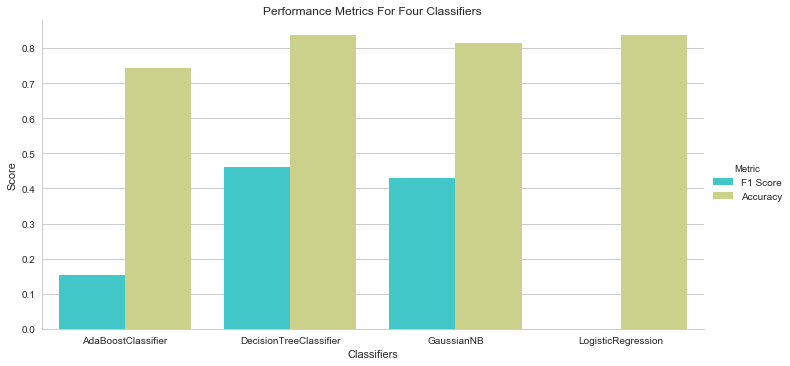

In [27]:
# Seperate the data into training set and test set
features_train, features_test, labels_train, labels_test = \
    train_test_split(selected_features, labels, test_size=0.3, random_state= 71)
    
random_state = 10
# Initialize the four models
clf_A = GaussianNB()
clf_B = LogisticRegression(random_state = random_state)
clf_C = DecisionTreeClassifier(random_state = random_state)
clf_D = AdaBoostClassifier(random_state = random_state)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]: 
    clf_name = clf.__class__.__name__
    clf.fit(features_train, labels_train)
    predictions = clf.predict(features_test)
        
    results[clf_name] = {}
    results[clf_name]['Accuracy'] = accuracy_score(labels_test,predictions)
    results[clf_name]['F1 Score'] = f1_score(labels_test,predictions)

# Convert the classification results to dataframe
results_df = pd.DataFrame.from_dict(results, orient='index', dtype=np.float)
results_df.reset_index(inplace=True)
results_df = pd.melt(results_df, id_vars="index", var_name="Metric", value_name = 'Score')
results_df.rename(columns={'index': 'Classifier'}, inplace=True)

# Plot the performance metrics for four classifiers
sns.set_style('whitegrid')
sns.factorplot(x='Classifier', y='Score', hue='Metric', data=results_df,
               kind='bar',palette='rainbow',
               size = 5, aspect = 2);
plt.xlabel('Classifiers')
plt.ylabel('Score')
plt.title("Performance Metrics For Four Classifiers");

The plot shows that decision tree model has highest values for both accuracy and F1 score. Therefore, it is chosen as the final model for tuning. It is also interesting to note that simple model like Naive Bayes can achieve performance comparable to more sophisticated decision tree model. 

### Model Tuning

Some algorithms have different parameters that can be changed. Tweaking these parameters and trying different parameter combinations could change the performance of the algorithms. We use grid search cross validation ([GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) via Sklearn) to tune the parameters of the decision tree model. The [parameters](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to be tuned are `'max_depth'`, `'min_samples_leaf'`, `'criterion'` and `'splitter'`. [F1](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) is used as the scoring function and [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is used to generate cross-validation dataset.


In [102]:
# Seperate the data into training set and test set
features_train, features_test, labels_train, labels_test = \
    train_test_split(selected_features, labels, test_size = 0.3, random_state = 789)

# Initialize the classifier
clf = DecisionTreeClassifier(random_state = 485)

# Create the parameters list
parameters  = {'max_depth': np.arange(3, 15),'min_samples_leaf': np.arange(5, 15),
              'criterion': ['gini','entropy'], 'splitter' : ['best','random']}

# Create the scoring function
scorer = make_scorer(f1_score)  

# Generate cross-validation dataset
cv = StratifiedShuffleSplit(labels_train, n_iter = 10, random_state = 42)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator = clf, param_grid = parameters, scoring = scorer, cv = cv)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(features_train, labels_train)

# Get the best estimator
best_estimator = grid_fit.best_estimator_

# Make predictions using the default and optimized models
predictions = (clf.fit(features_train, labels_train)).predict(features_test)
best_predictions = best_estimator.predict(features_test)



Best parameters:
{'splitter': 'best', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 13}

Unoptimized Model
------
Accuracy score on testing data: 0.8605
Precision on testing data: 0.5000
Recall on testing data: 0.3333
F1-score on testing data: 0.4000

Optimized Model
------
Final accuracy score on the testing data: 0.8837
Final precision on testing data: 0.6667
Final recall on testing data: 0.3333
Final F1-score on the testing data: 0.4444


             precision    recall  f1-score   support

        0.0       0.90      0.97      0.94        37
        1.0       0.67      0.33      0.44         6

avg / total       0.87      0.88      0.87        43



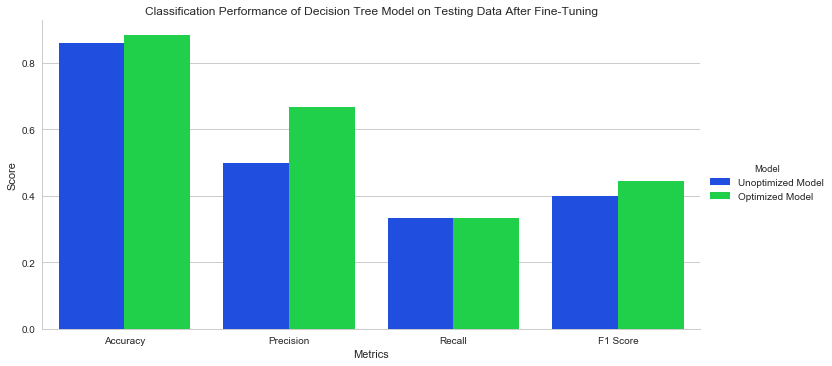

In [103]:
# Collect the prediction results
results = {}
results['Unoptimized Model'] = {}
results['Unoptimized Model']['Accuracy'] = accuracy_score(labels_test, predictions)
results['Unoptimized Model']['F1 Score'] = f1_score(labels_test, predictions)
results['Unoptimized Model']['Precision'] = precision_score(labels_test, predictions)
results['Unoptimized Model']['Recall'] = recall_score(labels_test, predictions)

results['Optimized Model'] = {}
results['Optimized Model']['Accuracy'] = accuracy_score(labels_test,best_predictions)
results['Optimized Model']['F1 Score'] = f1_score(labels_test, best_predictions)
results['Optimized Model']['Precision'] = precision_score(labels_test, best_predictions)
results['Optimized Model']['Recall'] = recall_score(labels_test, best_predictions)

# Report the before-and-after scores
print '\nBest parameters:'
print grid_fit.best_params_
print "\nUnoptimized Model\n------"
print "Accuracy score on testing data: {:.4f}".format(results['Unoptimized Model']['Accuracy'])
print "Precision on testing data: {:.4f}".format(results['Unoptimized Model']['Precision'])
print "Recall on testing data: {:.4f}".format(results['Unoptimized Model']['Recall'])
print "F1-score on testing data: {:.4f}".format(results['Unoptimized Model']['F1 Score'])
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(results['Optimized Model']['Accuracy'])
print "Final precision on testing data: {:.4f}".format(results['Optimized Model']['Precision'])
print "Final recall on testing data: {:.4f}".format(results['Optimized Model']['Recall'])
print "Final F1-score on the testing data: {:.4f}".format(results['Optimized Model']['F1 Score'])
print '\n'
print classification_report(labels_test, best_predictions)

# Convert the classification results to dataframe
results_df = pd.DataFrame.from_dict(results, orient='index', dtype=np.float)
results_df.reset_index(inplace=True)
results_df = pd.melt(results_df, id_vars="index", var_name="Metric", value_name = 'Score')
results_df.rename(columns={'index': 'Model'}, inplace=True)

# Plot the results
sns.set_style('whitegrid')
sns.factorplot(x='Metric', y='Score', hue='Model', data=results_df,
               order = ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
               hue_order = ['Unoptimized Model','Optimized Model'],
               kind='bar',palette='bright',
               size = 5, aspect = 2);
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title("Classification Performance of Decision Tree Model on Testing Data After Fine-Tuning");

After fine-tuning, the optimized model outperformed unoptimized model in all metrics but recall. 

## 6. Validation and Evaluation

### Validation Strategy and Performance Metrics

The purpose of validation in learning algorithm training is to avoid overfitting. This is achieved by splitting the dataset into 70% training set and 30% testing set in the above process. If all dataset is used in training, the model may perform well on this dataset, but perform poorly on new data that the model has never seen. 

Four metrics are used to evaluate the classification performance. Accuracy measures the number of correct predictions. Precision measures a classifiers exactness and the recall measures a classifiers completeness. In the context of this project, precision indicates the proportion of number of actual POI among all the employees identified by the model as POI. Recall indicates the proportion of the employees identified by the model as POI among all actual POI in the Enron scandal. F1 score is the weighted average of precision and recall. In small dataset with uneven class distribution, precision, recall and F1 score are more useful than accuracy. Therefore, F1 score is used as scoring function in the `'GridSearchCV'`. 


### Final Model Evaluation


The performance of the optimized model is evaluated by using `'test_classifier'` function in `'tester.py'` script. This function uses stratified ['StratifiedShuffleSplit'](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) cross validation due to small dataset. Compared with simpler cross-validation method such as ['train_test_split'](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), `'StratifiedShuffleSplit'` will make randomly chosen training and test sets multiple times and average the results over all the tests. The Enron data is also unbalanced with many more non-POIs than POIs. `'StratifidShuffleSplit'` makes sure that the ratio of non-POI:POI is the same in the training and test sets as it was in the larger data set. The performance of the final model evaluated by using `'StratifiedShuffleSplit'` is more robust compared with evaluation by using other methods.

In [105]:
# Convert the data to dictionary to be compatible with 'test_classifier' input format
selected_features_df = pd.DataFrame(data = selected_features, columns = selected_features_list)
labels_df = pd.DataFrame(data = labels)

my_dataset_df = pd.concat([labels_df, selected_features_df], axis=1)
my_dataset = pd.DataFrame.to_dict(my_dataset_df, orient='index')

# Dump the classifier, dataset, and features_list as pickle files
dump_classifier_and_data(best_estimator, my_dataset, list(my_dataset_df.columns))

# Pass the optimized model to the 'test_classifier' function
test_classifier(best_estimator, my_dataset, list(my_dataset_df.columns))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=13,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=485, splitter='best')
	Accuracy: 0.84207	Precision: 0.38618	Recall: 0.31300	F1: 0.34576	F2: 0.32533
	Total predictions: 15000	True positives:  626	False positives:  995	False negatives: 1374	True negatives: 12005



## 7. Summary



The objective of this project is using machine learning methods to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset. Initial data exploration reveals that the dataset is small, has a lot of missing value, outliers and unbalance class distribution. These are common characteristics found in real-world dataset. We removed all the outliers from the dataset and replaced all missing values by '0' during data auditing.

We also created two new features based on original email features of the dataset. By using feature selection function `'SelectKBest'`, six most importance features were selected to build the learning models. One of them is the new engineered feature.

Next, we compared the classification performance of different machine learning models based on the selected features. To avoid overfitting, the dataset was partitioned into training and testing sets. Decision tree classifier with highest F1 score was chosen to be the final mode. The parameters of the model were optimized by using `'GridSearchCV'`. Both precision and recall scores of the final model are greater than 0.3 after parameter tuning.
